In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Imports & Configurations

In [ ]:
# === Basic Utilities ===
import os, random, shutil, warnings
from pathlib import Path
from collections import defaultdict, Counter

# === Data Handling ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.cluster import DBSCAN
from time import time

# === Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt

# === Image Handling ===
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.simplefilter('error', Image.DecompressionBombWarning)

# === TensorFlow & Keras ===
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers


import torch
from tqdm import tqdm

# 2. GPU enabling and optimizations

In [ ]:
# Force GPU processing
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPUs Available: {len(physical_devices)}")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print(f"Memory growth set to True for {device}")
    print("GPU processing enabled")
else:
    print("No GPU devices found. Running on CPU")

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'

GPUs Available: 1
Memory growth set to True for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU processing enabled


# 3. Functional API (Multi-Output Model)

- Uses a shared CNN feature extractor
- Predicts Phylum (coarse class) and Family (fine class)
- Combines phylum output back into the family prediction head
- Uses modular, named layers for clarity
- Is ready for multi-loss compilation and visualization

In [ ]:
# Paths to train, validation and test datasets
train_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_sample_stratified/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_sample_stratified/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_sample_stratified/test'

# Load updated metadata
metadata_path = r"/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_sample_stratified/metadata.csv"
metadata = pd.read_csv(metadata_path)

# Encode categorical labels
metadata['phylum_id'] = metadata['phylum'].astype('category').cat.codes
metadata['family_id'] = metadata['family'].astype('category').cat.codes

# Create class index to (phylum_id, family_id) lookup
class_names = sorted(metadata['family'].astype('category').cat.categories.tolist())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Mapping: class_idx -> (phylum_id, family_id)
class_idx_to_phylum_family = {}

for _, row in metadata.iterrows():
    family = row['family']
    class_idx = class_to_idx[family]
    phylum_id = row['phylum_id']
    family_id = row['family_id']
    if class_idx not in class_idx_to_phylum_family:
        class_idx_to_phylum_family[class_idx] = (phylum_id, family_id)

# Convert to tensor constant (for TensorFlow map)
lookup_array = np.zeros((len(class_idx_to_phylum_family), 2), dtype=np.int32)
for idx, (phylum_id, family_id) in class_idx_to_phylum_family.items():
    lookup_array[idx] = [phylum_id, family_id]

lookup_tensor = tf.constant(lookup_array)


def multitask_label_mapper(image, label):
    # label is an integer (class index)
    # Lookup (phylum_id, family_id) based on class index
    phylum_family = tf.gather(lookup_tensor, label)
    phylum_label = phylum_family[0]
    family_label = phylum_family[1]
    return image, {
        'phylum_output': phylum_label,
        'family_output': family_label
    }


# Batch size and image quality
batch_size = 32
image_size = (224, 224)

# Loading train, validation and test
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=123,
)

train_dataset = (
    train_dataset
    .unbatch()
    .map(multitask_label_mapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .repeat()  # <--- ADD THIS
    .prefetch(tf.data.AUTOTUNE)
)


val_dataset = image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False,
)

val_dataset = (
    val_dataset
    .unbatch()
    .map(multitask_label_mapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


test_dataset = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False,
)

test_dataset = (
    test_dataset
    .unbatch()
    .map(multitask_label_mapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# Model creation
def build_multitask_species_model(input_shape=(224, 224, 3), num_phyla=5, num_families=202):
    l2 = regularizers.l2(0.0005)
    inputs = Input(shape=input_shape, name="image_input")

    # Block 1
    x = Conv2D(64, (3, 3), strides=1, padding='same', kernel_regularizer=l2, name="conv1")(inputs)
    x = BatchNormalization(name="bn1")(x)
    x = Activation('relu', name="act1")(x)
    x = MaxPooling2D((2, 2), name="pool1")(x)
    x = Dropout(0.1, name="drop1")(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2, name="conv2a")(x)
    x = BatchNormalization(name="bn2a")(x)
    x = Activation('relu', name="act2a")(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2, name="conv2b")(x)
    x = BatchNormalization(name="bn2b")(x)
    x = Activation('relu', name="act2b")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)
    x = Dropout(0.2, name="drop2")(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2, name="conv3")(x)
    x = BatchNormalization(name="bn3")(x)
    x = Activation('relu', name="act3")(x)
    x = MaxPooling2D((2, 2), name="pool3")(x)
    x = Dropout(0.3, name="drop3")(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2, name="conv4")(x)
    x = BatchNormalization(name="bn4")(x)
    x = Activation('relu', name="act4")(x)
    x = MaxPooling2D((2, 2), name="pool4")(x)
    x = Dropout(0.4, name="drop4")(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2, name="conv5")(x)
    x = BatchNormalization(name="bn5")(x)
    x = Activation('relu', name="act5")(x)
    x = GlobalAveragePooling2D(name="gap")(x)
    x = Dropout(0.4, name="drop5")(x)

    # Shared Dense Base
    base_features = Dense(512, kernel_regularizer=l2, name="dense_shared_1")(x)
    base_features = BatchNormalization(name="bn_fc_1")(base_features)
    base_features = Activation('relu', name="act_fc_1")(base_features)
    base_features = Dropout(0.5, name="drop_fc_1")(base_features)

    base_features = Dense(128, kernel_regularizer=l2, name="dense_shared_2")(base_features)
    base_features = BatchNormalization(name="bn_fc_2")(base_features)
    base_features = Activation('relu', name="act_fc_2")(base_features)
    base_features = Dropout(0.3, name="drop_fc_2")(base_features)

    # Phylum Output
    phylum_branch = Dense(64, activation='relu', name="phylum_fc")(base_features)
    phylum_output = Dense(num_phyla, activation='softmax', name="phylum_output")(phylum_branch)

    # Family Output (Conditioned on Phylum)
    concat = Concatenate(name="concat_family_phylum")([base_features, phylum_output])
    family_branch = Dense(256, activation='relu', name="family_fc")(concat)
    family_output = Dense(num_families, activation='softmax', name="family_output")(family_branch)

    return Model(inputs=inputs, outputs=[phylum_output, family_output], name="Multitask_Species_Model")

num_phyla = metadata['phylum'].nunique()
num_families = metadata['family'].nunique()

model = build_multitask_species_model(
    input_shape=(224, 224, 3),
    num_phyla=num_phyla,
    num_families=num_families
)

# Compile Functional Multitask Model
model.compile(
    optimizer='adam',
    loss={
        'phylum_output': 'sparse_categorical_crossentropy',
        'family_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'phylum_output': 0.5,
        'family_output': 1.0
    },
    metrics={
        'phylum_output': ['accuracy'],
        'family_output': ['accuracy']
    }
)

# Model summary table
model.summary()


# Training Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_family_output_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        "best_multitask_model.h5",
        monitor='val_family_output_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_family_output_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    )
]

# number of training samples
num_train_samples = 4789
steps_per_epoch = num_train_samples // batch_size

# Fitting the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=35,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks
)


Found 4789 files belonging to 202 classes.
Found 1026 files belonging to 202 classes.
Found 1027 files belonging to 202 classes.


Model: "Multitask_Species_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 224, 224,  │      1,792 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 224, 224,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act1 (Activation)   │ (None, 224, 224,  │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 112, 112,  │          0 │ act1[0][0]        │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 112, 112,  │          0 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2a (Conv2D)     │ (None, 112, 112,  │     73,856 │ drop1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a                │ (None, 112, 112,  │        512 │ conv2a[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act2a (Activation)  │ (None, 112, 112,  │          0 │ bn2a[0][0]        │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2b (Conv2D)     │ (None, 112, 112,  │    147,584 │ act2a[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2b                │ (None, 112, 112,  │        512 │ conv2b[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act2b (Activation)  │ (None, 112, 112,  │          0 │ bn2b[0][0]        │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 56, 56,    │          0 │ act2b[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop2 (Dropout)     │ (None, 56, 56,    │          0 │ pool2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 56, 56,    │    295,168 │ drop2[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 56, 56,    │      1,024 │ conv3[0][0]       │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act3 (Activation)   │ (None, 56, 56,    │          0 │ bn3[0][0]       

 Total params: 4,490,447 (17.13 MB)

 Trainable params: 4,485,967 (17.11 MB)

 Non-trainable params: 4,480 (17.50 KB)

Epoch 1/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - family_output_accuracy: 0.0204 - family_output_loss: 5.2223 - loss: 6.7217 - phylum_output_accuracy: 0.6790 - phylum_output_loss: 1.0319
Epoch 1: val_family_output_accuracy improved from -inf to 0.02729, saving model to best_multitask_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


149/149 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - family_output_accuracy: 0.0205 - family_output_loss: 5.2216 - loss: 6.7201 - phylum_output_accuracy: 0.6795 - phylum_output_loss: 1.0309 - val_family_output_accuracy: 0.0273 - val_family_output_loss: 5.3275 - val_loss: 6.5254 - val_phylum_output_accuracy: 0.7622 - val_phylum_output_loss: 0.9118 - learning_rate: 0.0010
Epoch 2/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - family_output_accuracy: 0.0520 - family_output_loss: 4.9098 - loss: 6.0050 - phylum_output_accuracy: 0.7917 - phylum_output_loss: 0.7591
Epoch 2: val_family_output_accuracy improved from 0.02729 to 0.05653, saving model to best_multitask_model.h5


149/149 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - family_output_accuracy: 0.0520 - family_output_loss: 4.9098 - loss: 6.0046 - phylum_output_accuracy: 0.7917 - phylum_output_loss: 0.7591 - val_family_output_accuracy: 0.0565 - val_family_output_loss: 5.0855 - val_loss: 6.0289 - val_phylum_output_accuracy: 0.7865 - val_phylum_output_loss: 0.9281 - learning_rate: 0.0010
Epoch 3/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - family_output_accuracy: 0.0692 - family_output_loss: 4.7839 - loss: 5.6803 - phylum_output_accuracy: 0.7870 - phylum_output_loss: 0.7402
Epoch 3: val_family_output_accuracy improved from 0.05653 to 0.05750, saving model to best_multitask_model.h5


149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - family_output_accuracy: 0.0692 - family_output_loss: 4.7840 - loss: 5.6801 - phylum_output_accuracy: 0.7870 - phylum_output_loss: 0.7403 - val_family_output_accuracy: 0.0575 - val_family_output_loss: 4.9059 - val_loss: 5.7010 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8550 - learning_rate: 0.0010
Epoch 4/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - family_output_accuracy: 0.0700 - family_output_loss: 4.7357 - loss: 5.5385 - phylum_output_accuracy: 0.7836 - phylum_output_loss: 0.7672
Epoch 4: val_family_output_accuracy did not improve from 0.05750
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - family_output_accuracy: 0.0700 - family_output_loss: 4.7358 - loss: 5.5384 - phylum_output_accuracy: 0.7836 - phylum_output_loss: 0.7672 - val_family_output_accuracy: 0.0419 - val_family_output_loss: 5.0930 - val_loss: 5.8447 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8738 - learning_rate: 0.0010
Epoch 5/35

149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - family_output_accuracy: 0.0784 - family_output_loss: 4.6489 - loss: 5.3520 - phylum_output_accuracy: 0.7957 - phylum_output_loss: 0.7254 - val_family_output_accuracy: 0.0682 - val_family_output_loss: 4.7811 - val_loss: 5.4591 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8576 - learning_rate: 0.0010
Epoch 7/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - family_output_accuracy: 0.0772 - family_output_loss: 4.6367 - loss: 5.3111 - phylum_output_accuracy: 0.7944 - phylum_output_loss: 0.7198
Epoch 7: val_family_output_accuracy improved from 0.06823 to 0.08187, saving model to best_multitask_model.h5


149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - family_output_accuracy: 0.0772 - family_output_loss: 4.6366 - loss: 5.3111 - phylum_output_accuracy: 0.7943 - phylum_output_loss: 0.7199 - val_family_output_accuracy: 0.0819 - val_family_output_loss: 4.9089 - val_loss: 5.5323 - val_phylum_output_accuracy: 0.7885 - val_phylum_output_loss: 0.8998 - learning_rate: 0.0010
Epoch 8/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - family_output_accuracy: 0.0746 - family_output_loss: 4.6269 - loss: 5.2942 - phylum_output_accuracy: 0.7903 - phylum_output_loss: 0.7381
Epoch 8: val_family_output_accuracy did not improve from 0.08187
149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - family_output_accuracy: 0.0747 - family_output_loss: 4.6268 - loss: 5.2941 - phylum_output_accuracy: 0.7903 - phylum_output_loss: 0.7382 - val_family_output_accuracy: 0.0565 - val_family_output_loss: 4.9507 - val_loss: 5.6028 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8466 - learning_rate: 0.0010
Epoch 9/35

149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - family_output_accuracy: 0.0983 - family_output_loss: 4.4195 - loss: 5.0127 - phylum_output_accuracy: 0.7923 - phylum_output_loss: 0.7149 - val_family_output_accuracy: 0.0828 - val_family_output_loss: 4.6474 - val_loss: 5.2154 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8391 - learning_rate: 5.0000e-04
Epoch 13/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - family_output_accuracy: 0.0965 - family_output_loss: 4.4049 - loss: 4.9901 - phylum_output_accuracy: 0.7928 - phylum_output_loss: 0.7138
Epoch 13: val_family_output_accuracy did not improve from 0.08285
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - family_output_accuracy: 0.0965 - family_output_loss: 4.4050 - loss: 4.9901 - phylum_output_accuracy: 0.7928 - phylum_output_loss: 0.7139 - val_family_output_accuracy: 0.0750 - val_family_output_loss: 4.7667 - val_loss: 5.2776 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8827 - learning_rate: 5.0000e-04


149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - family_output_accuracy: 0.0907 - family_output_loss: 4.3805 - loss: 4.9516 - phylum_output_accuracy: 0.7984 - phylum_output_loss: 0.6953 - val_family_output_accuracy: 0.0897 - val_family_output_loss: 4.6837 - val_loss: 5.1769 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8876 - learning_rate: 5.0000e-04
Epoch 15/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - family_output_accuracy: 0.0996 - family_output_loss: 4.3648 - loss: 4.9480 - phylum_output_accuracy: 0.7865 - phylum_output_loss: 0.7303
Epoch 15: val_family_output_accuracy did not improve from 0.08967
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - family_output_accuracy: 0.0996 - family_output_loss: 4.3648 - loss: 4.9480 - phylum_output_accuracy: 0.7865 - phylum_output_loss: 0.7303 - val_family_output_accuracy: 0.0828 - val_family_output_loss: 4.6840 - val_loss: 5.2088 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8738 - learning_rate: 5.0000e-04


149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - family_output_accuracy: 0.1015 - family_output_loss: 4.2783 - loss: 4.8280 - phylum_output_accuracy: 0.7872 - phylum_output_loss: 0.7142 - val_family_output_accuracy: 0.0975 - val_family_output_loss: 4.5225 - val_loss: 4.9860 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8229 - learning_rate: 2.5000e-04
Epoch 20/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - family_output_accuracy: 0.1101 - family_output_loss: 4.2579 - loss: 4.7985 - phylum_output_accuracy: 0.7890 - phylum_output_loss: 0.7140
Epoch 20: val_family_output_accuracy did not improve from 0.09747
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - family_output_accuracy: 0.1101 - family_output_loss: 4.2578 - loss: 4.7984 - phylum_output_accuracy: 0.7890 - phylum_output_loss: 0.7140 - val_family_output_accuracy: 0.0867 - val_family_output_loss: 4.5849 - val_loss: 5.1146 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8058 - learning_rate: 2.5000e-04


149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - family_output_accuracy: 0.1132 - family_output_loss: 4.1543 - loss: 4.6850 - phylum_output_accuracy: 0.7850 - phylum_output_loss: 0.7197 - val_family_output_accuracy: 0.1023 - val_family_output_loss: 4.5147 - val_loss: 4.9847 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.7967 - learning_rate: 1.2500e-04
Epoch 25/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - family_output_accuracy: 0.1238 - family_output_loss: 4.1369 - loss: 4.6551 - phylum_output_accuracy: 0.7829 - phylum_output_loss: 0.7054
Epoch 25: val_family_output_accuracy did not improve from 0.10234
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - family_output_accuracy: 0.1237 - family_output_loss: 4.1368 - loss: 4.6551 - phylum_output_accuracy: 0.7830 - phylum_output_loss: 0.7054 - val_family_output_accuracy: 0.1014 - val_family_output_loss: 4.4907 - val_loss: 4.9450 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.7988 - learning_rate: 1.2500e-04


149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - family_output_accuracy: 0.1168 - family_output_loss: 4.1386 - loss: 4.6544 - phylum_output_accuracy: 0.7834 - phylum_output_loss: 0.7064 - val_family_output_accuracy: 0.1082 - val_family_output_loss: 4.4837 - val_loss: 4.9147 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8176 - learning_rate: 1.2500e-04
Epoch 27/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - family_output_accuracy: 0.1173 - family_output_loss: 4.1490 - loss: 4.6766 - phylum_output_accuracy: 0.7793 - phylum_output_loss: 0.7296
Epoch 27: val_family_output_accuracy did not improve from 0.10819
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - family_output_accuracy: 0.1174 - family_output_loss: 4.1488 - loss: 4.6763 - phylum_output_accuracy: 0.7794 - phylum_output_loss: 0.7295 - val_family_output_accuracy: 0.0955 - val_family_output_loss: 4.4987 - val_loss: 4.9363 - val_phylum_output_accuracy: 0.7895 - val_phylum_output_loss: 0.8184 - learning_rate: 1.2500e-04


149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - family_output_accuracy: 0.1218 - family_output_loss: 4.0590 - loss: 4.5619 - phylum_output_accuracy: 0.7800 - phylum_output_loss: 0.7063 - val_family_output_accuracy: 0.1131 - val_family_output_loss: 4.4827 - val_loss: 4.8611 - val_phylum_output_accuracy: 0.7914 - val_phylum_output_loss: 0.8039 - learning_rate: 6.2500e-05
Epoch 33/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - family_output_accuracy: 0.1318 - family_output_loss: 4.0380 - loss: 4.5417 - phylum_output_accuracy: 0.7809 - phylum_output_loss: 0.7120
Epoch 33: val_family_output_accuracy did not improve from 0.11306
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - family_output_accuracy: 0.1318 - family_output_loss: 4.0379 - loss: 4.5416 - phylum_output_accuracy: 0.7810 - phylum_output_loss: 0.7119 - val_family_output_accuracy: 0.1131 - val_family_output_loss: 4.4184 - val_loss: 4.8217 - val_phylum_output_accuracy: 0.7914 - val_phylum_output_loss: 0.8025 - learning_rate: 6.2500e-05


149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - family_output_accuracy: 0.1302 - family_output_loss: 4.0530 - loss: 4.5571 - phylum_output_accuracy: 0.7798 - phylum_output_loss: 0.7151 - val_family_output_accuracy: 0.1199 - val_family_output_loss: 4.4137 - val_loss: 4.8194 - val_phylum_output_accuracy: 0.7924 - val_phylum_output_loss: 0.8017 - learning_rate: 6.2500e-05
Epoch 35/35
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - family_output_accuracy: 0.1251 - family_output_loss: 4.0412 - loss: 4.5464 - phylum_output_accuracy: 0.7784 - phylum_output_loss: 0.7230
Epoch 35: val_family_output_accuracy did not improve from 0.11988
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - family_output_accuracy: 0.1251 - family_output_loss: 4.0411 - loss: 4.5462 - phylum_output_accuracy: 0.7784 - phylum_output_loss: 0.7228 - val_family_output_accuracy: 0.1053 - val_family_output_loss: 4.4671 - val_loss: 4.8473 - val_phylum_output_accuracy: 0.7934 - val_phylum_output_loss: 0.8018 - learning_rate: 6.2500e-05


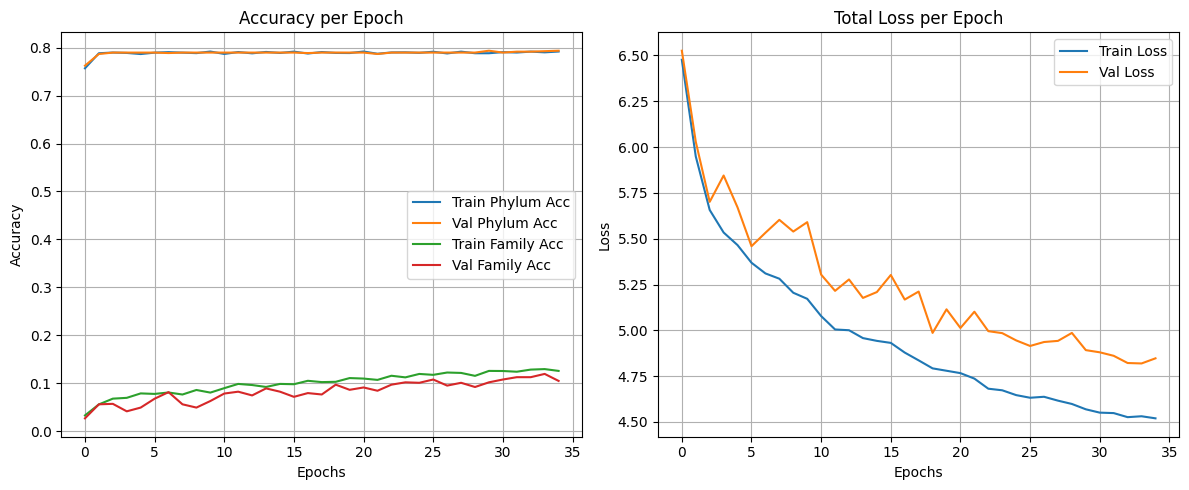

In [ ]:
# Plot evaluation metrics
def plot_training(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['phylum_output_accuracy'], label='Train Phylum Acc')
    plt.plot(history.history['val_phylum_output_accuracy'], label='Val Phylum Acc')
    plt.plot(history.history['family_output_accuracy'], label='Train Family Acc')
    plt.plot(history.history['val_family_output_accuracy'], label='Val Family Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Total Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training(history)

In [ ]:
# Run Predictions
predictions = model.predict(test_dataset)

# Unpack predictions
y_pred_phylum = np.argmax(predictions[0], axis=1)
y_pred_family = np.argmax(predictions[1], axis=1)

# Extract true labels (already integer-encoded, not one-hot)
y_true_phylum = np.concatenate([y["phylum_output"] for _, y in test_dataset], axis=0)
y_true_family = np.concatenate([y["family_output"] for _, y in test_dataset], axis=0)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# Classification report on Phylum
print("Classification Report — Phylum (Coarse Level):\n")
print(classification_report(y_true_phylum, y_pred_phylum, digits=4))
print("Macro F1-score (Phylum):", f1_score(y_true_phylum, y_pred_phylum, average='macro'))

Classification Report — Phylum (Coarse Level):

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        96
           1     0.7892    0.9988    0.8817       806
           2     0.8571    0.0612    0.1143        98
           3     0.0000    0.0000    0.0000         6
           4     0.0000    0.0000    0.0000        21

    accuracy                         0.7897      1027
   macro avg     0.3293    0.2120    0.1992      1027
weighted avg     0.7012    0.7897    0.7029      1027

Macro F1-score (Phylum): 0.19919887341574088


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Classification report on Family
print("Classification Report — Family (Fine Level):\n")
print(classification_report(y_true_family, y_pred_family, digits=4))
print("Macro F1-score (Family):", f1_score(y_true_family, y_pred_family, average='macro'))

Classification Report — Family (Fine Level):

              precision    recall  f1-score   support

           0     0.2895    0.7857    0.4231        14
           1     0.0000    0.0000    0.0000         2
           2     0.0000    0.0000    0.0000         6
           3     0.0000    0.0000    0.0000         3
           4     0.0000    0.0000    0.0000         3
           5     0.2432    0.7826    0.3711        23
           6     0.0000    0.0000    0.0000         6
           7     0.0000    0.0000    0.0000         3
           8     0.0000    0.0000    0.0000         3
           9     0.0000    0.0000    0.0000         2
          10     0.0000    0.0000    0.0000         2
          11     0.0000    0.0000    0.0000         3
          12     0.0000    0.0000    0.0000         3
          13     0.0000    0.0000    0.0000         3
          14     0.0000    0.0000    0.0000         2
          15     0.0000    0.0000    0.0000         2
          16     0.0000    0.0000  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
